# Final Project: Analyzing a Supernova (SN 2020tlf)

**Author:** Insan Adhikari  
**Course:** Intro to Astronomy  
**Project:** Option 1 – Analyzing a Supernova  
**Target:** SN 2020tlf

In this project, we explore the redshift, hydrogen emission lines, and circumstellar material of the Type IIp supernova SN 2020tlf.

---
## Step 1: Read in the FITS spectrum
We'll start by loading the spectral data for SN 2020tlf from the provided FITS file.


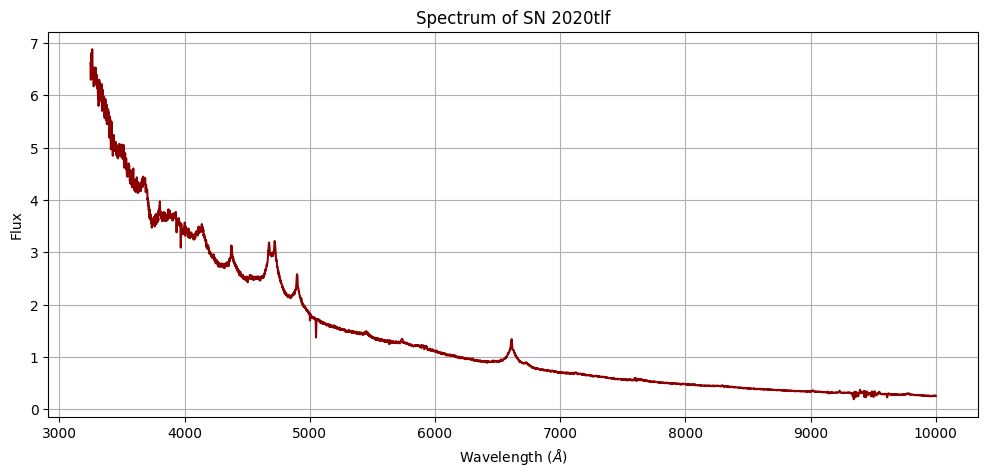

In [149]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# Load the FITS file
hdul = fits.open("SN2020tlf_spec.fits")
data = hdul[1].data
wavelength = data['wavelength']
flux = data['flux']

# Spectrum of SN 2020tlf
plt.figure(figsize=(12, 5))
plt.plot(wavelength, flux, color='darkred')
plt.title("Spectrum of SN 2020tlf")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Flux")
plt.grid(True)
plt.savefig("spectrum_sn2020tlf.png", dpi=300)
plt.show()


---
## Step 2: Calculate Hydrogen Balmer Series

We calculate and overlay the Balmer series transitions from n=3 to n=7 onto the spectrum using the Rydberg formula:
$$
\lambda = R \left(\frac{1}{2^2} - \frac{1}{n^2}\right)^{-1}
$$\\
where
$$
 R = 1.097 \times 10^7 \, \text{m}^{-1}.
$$


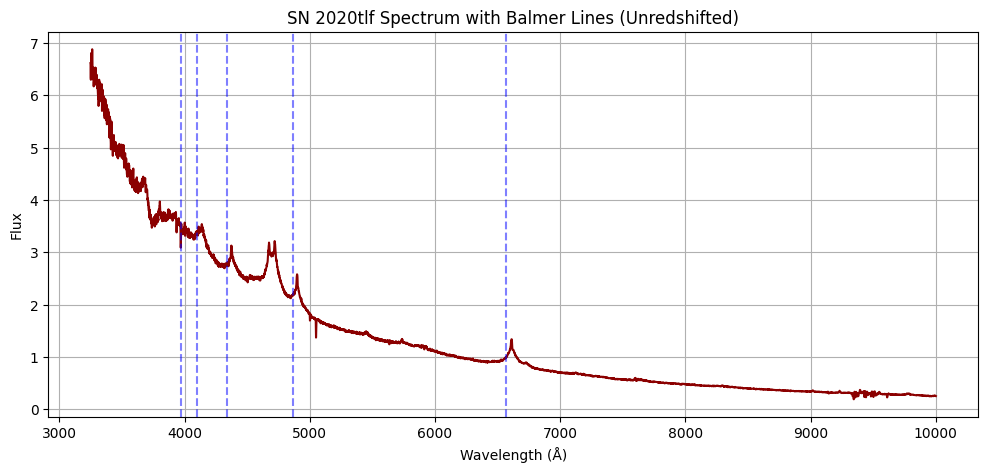

In [150]:
# Rydberg constant in m^-1
R = 1.097e7
n_vals = np.arange(3, 8)
lambda_rest = [1 / (R * ((1/4) - (1/n**2))) * 1e10 for n in n_vals]  # in Å

# Plot with Balmer lines
plt.figure(figsize=(12, 5))
plt.plot(wavelength, flux, color='darkred')
for l in lambda_rest:
    plt.axvline(l, color='blue', linestyle='--', alpha=0.5)
plt.title("SN 2020tlf Spectrum with Balmer Lines (Unredshifted)")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.grid(True)
plt.savefig("balmer_lines_unredshifted.png", dpi=300)
plt.show()


---
## Step 3: Estimate Redshift by Eye

We'll shift the Balmer lines to match observed peaks and estimate redshift \( z \) using:

$$
z = \frac{\lambda_\text{observed} - \lambda_\text{rest}}{\lambda_\text{rest}}
$$

We'll compare this to values from Jacobson-Galán et al. (2021).


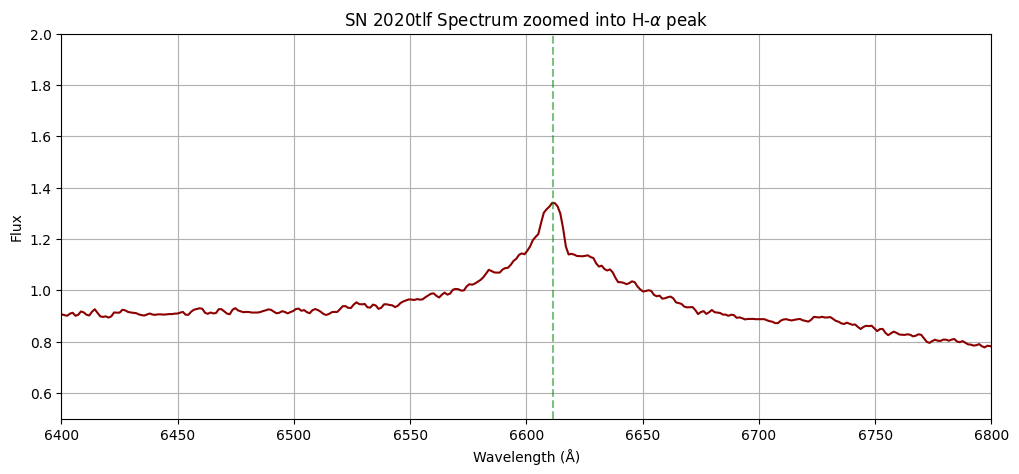

H-alpha rest wavelength: 6563.35 Å
Shifted H-alpha wavelength: 6611.354603463993
Redshift: 0.00731


In [151]:
# Apply redshift to Balmer lines
lambda_offset = 48  # Example offset manually adjusted until balmer lines fall onto observed peaks
lambda_ha_rest = lambda_rest[0]
alpha_lambda_shifted = lambda_ha_rest + lambda_offset

# Plot with shifted Balmer lines
plt.figure(figsize=(12, 5))
plt.plot(wavelength, flux, color='darkred')
plt.axvline(alpha_lambda_shifted, color='green', linestyle='--', alpha=0.5)
plt.title(f"SN 2020tlf Spectrum zoomed into H-$\\alpha$ peak")
plt.xlim(6400,6800)
plt.ylim(0.5,2)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.grid(True)
plt.show()

# Calculate redshift using H-alpha observed and rest wavelengths
print(f"H-alpha rest wavelength: {lambda_ha_rest:.2f} Å")
print(f"Shifted H-alpha wavelength: {alpha_lambda_shifted}") # Shifted lambda in angstroms

z = lambda_offset/lambda_ha_rest
print(f"Redshift: {z:.5f}")


#### Jacobson-Galán et al (2021) reports a redshift of z = 0.008463 ± 0.0003
#### Our answer of 0.00731 is close with a % error of ~ 14 % so this is not super accurate to the research paper 

---
## Step 4: Zoom in on the Hα Line

We zoom into ±100 Å around the redshifted Hα line and fit a Lorentzian function to measure line broadening.

Lorentzian model:
$$
f(\lambda) = \frac{A}{\pi} \cdot \frac{\Gamma/2}{(\lambda - \lambda_0)^2 + (\Gamma/2)^2} + B
$$


x range: 6581.4 – 6640.7
y range: 1.032e+00 – 1.341e+00


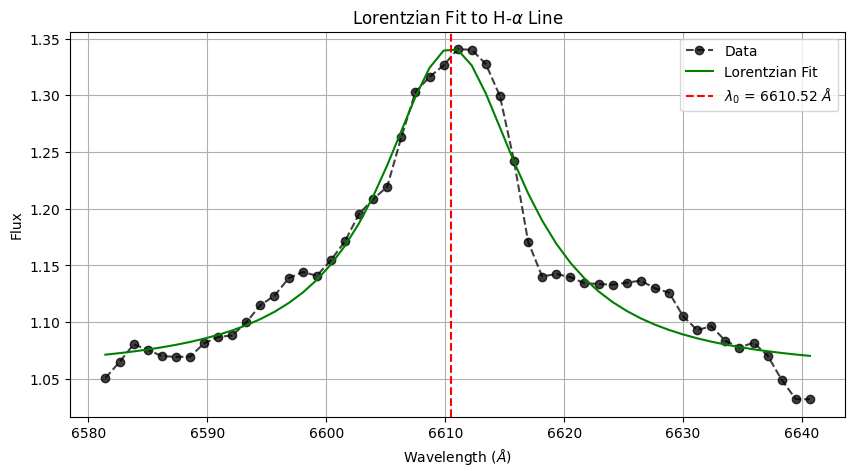

In [152]:
from scipy.optimize import curve_fit

# Lorentzian model
def lorentzian(wave, A, gamma, lambda0, B):
    return (A / np.pi) * (gamma / 2) / ((wave - lambda0)**2 + (gamma / 2)**2) + B




# Extract zoomed region
lambda_ha_shifted = lambda_ha_rest * (1 + z)
window = 30  # Å
mask = (wavelength > lambda_ha_shifted - window) & (wavelength < lambda_ha_shifted + window)
xdata = wavelength[mask]
ydata = flux[mask]

print(f"x range: {xdata.min():.1f} – {xdata.max():.1f}")
print(f"y range: {ydata.min():.3e} – {ydata.max():.3e}")


A_guess = ydata.max() - ydata.min()
gamma_guess = 5
lambda0_guess = xdata[np.argmax(ydata)]
B_guess = ydata.min()

p0 = [A_guess, gamma_guess, lambda0_guess, B_guess]


bounds = (
    [0, 0.1, lambda0_guess - 10, -np.inf],  # lower bounds
    [np.inf, 20, lambda0_guess + 10, np.inf]  # upper bounds
)


# Fit
p0 = [1e-14, 10, lambda_ha_shifted, 1e-15]
params, _ = curve_fit(lorentzian, xdata, ydata, p0=p0, bounds=bounds)
A_fit, gamma_fit, lambda0_fit, B_fit = params

# Plot fit
plt.figure(figsize=(10, 5))
plt.plot(xdata, ydata, '--o', label="Data", color='black', alpha=0.75)
plt.plot(xdata, lorentzian(xdata, *params), label="Lorentzian Fit", color='green')
plt.axvline(lambda0_fit, color='red', linestyle='--', label=f"$\lambda_0$ = {lambda0_fit:.2f} $\AA$")
plt.title("Lorentzian Fit to H-$\\alpha$ Line")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Flux")
plt.legend()
plt.grid(True)
plt.savefig("lorentzian_fit_ha.png", dpi=300)
plt.show()

---
## Step 5: Calculate Velocity from Line Broadening

The Lorentzian width \( \Gamma \) gives the velocity of the circumstellar material:

$$
v = \frac{c \cdot \Gamma}{\lambda_0}
$$


In [ ]:
c = 3e5  # km/s
v = (c * gamma_fit) / lambda0_fit
print(f"Estimated velocity of circumstellar material: v ≈ {v:.2f} km/s")


Estimated velocity of circumstellar material: v ≈ 651.88 km/s


Jacobson-Galán et al (2021) reports a LorLorentzian profile velocity of (∼300–400 km s−1), out value is over double their lower estimate for the velocity so this does not seem super accurate.

---
## Appendix: Astrobite Questions

See responses in the final report document.
